# Conjugate Priors

*Notebook to implement conjugate prior evaluation on pymc3*

In [58]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import arviz as az
import pymc as pm

import pyro
import pyro.distributions as pyro_dist
import torch
import pandas as pd

from cmdstanpy import CmdStanModel

import ddks

In [60]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Kullback-Leibler Divergence

In [488]:
#TODO: Refactor pdf_space to take a pdf argument and define the limits of the space according to the largest values within the space.

In [42]:
def _generate_array(start, end, n, reverse = False):
    # Generate an array with values from start to end with decreasing intervals
    try:
        d = start.shape[0]
    except IndexError:
        d = 1
        start = np.array([start])
        end = np.array([end])

    limits = np.column_stack((start, end))
    axes = []

    for i in range(d):
        arr = np.cumsum(np.exp(-np.linspace(0, 5, n)))
        if reverse:
            arr = arr[::-1]
        axes.append((arr - arr[0]) / (arr[-1] - arr[0]) * (limits[i, 1] - limits[i, 0]) + limits[i, 0])

    return np.array([np.array(x) for x in list(zip(*axes))])

def pdf_space(start, end, n = 10000):
    mean = np.array([start, end]).mean()
    arr2 = _generate_array(mean, end, int(n/2))
    arr1 = _generate_array(mean, start, int(n/2)) * -1
    return np.concatenate([arr1[::-1], arr2])

<BarContainer object of 199 artists>

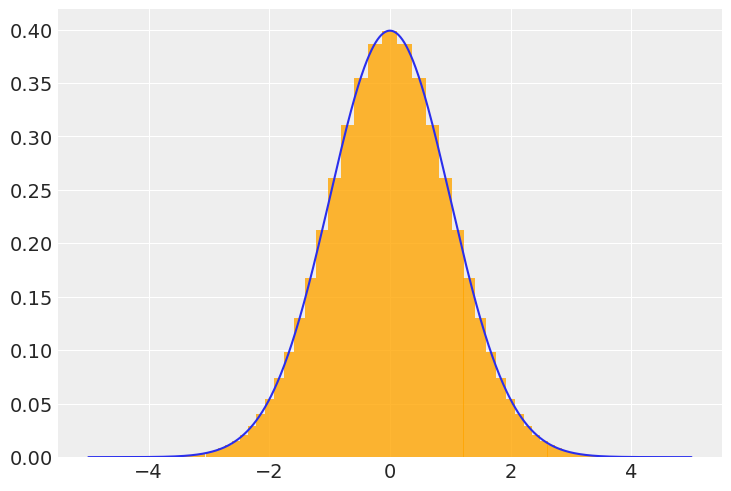

In [36]:
x1 = pdf_space(-5, 5, n = 200)
y1 = stats.norm(0, 1).pdf(x1)
h = np.diff(x1)

x2 = np.linspace(-5, 5, 1000)
y2  = stats.norm(0, 1).pdf(x2)

plt.plot(x2, y2)
plt.bar(x1[1:], y1[1:], color = "orange", alpha = 0.8, width = h)

# plt.xlabel("X")
# plt.ylabel("Y")




In [486]:
#(a+b)h/2

def integrate(function, space):
    y = function(space)

    h = np.diff(space)

    return np.sum((y[1:] + y[:-1]) * h / 2)

# calculate kullback leibler divergence using integrate function
def kl_divergence(p, q, start, end):
    space = pdf_space(start, end)
    print(space)
    return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)

In [487]:
kl_divergence(stats.norm(10, 7), stats.norm(5,7), -np.inf, np.inf)

[-147457.39533719 -147308.98217809 -147160.71738763 ...  147160.71738763
  147308.98217809  147457.39533719]


/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: divide by zero encountered in divide
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: invalid value encountered in divide
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: divide by zero encountered in log
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: invalid value encountered in multiply
  return integrate(lambda x: p

nan

## Normal distribution with known variance, unknown mean

$$
\sigma = 1\\
$$

$$
P(x|\Theta) \sim \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu, 1)\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\mu_0, \sigma_0^2)\\
$$

$$
P(\tilde{x}|\Theta') \sim \mathcal{N}(\frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}), (\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2})^{-1})
$$

### Scratch

In [41]:
n = 1000
sigma = 3
mu = 9

X1 = rng.normal(size = n, loc = mu, scale = sigma)
prior_mean = 6
prior_std = 3

posterior_mean = np.power((1/np.power(prior_std, 2))+(n/np.power(sigma,2)), -1)*((prior_mean/np.power(prior_std, 2)) + (X.sum()/np.power(sigma, 2)))
posterior_std = np.power((1 / np.power(prior_std, 2)) + (n/np.power(sigma, 2)), -1)

scratch_prior = stats.norm(prior_mean, prior_std)
scratch_predictive = stats.norm(posterior_mean, posterior_std + prior_std)

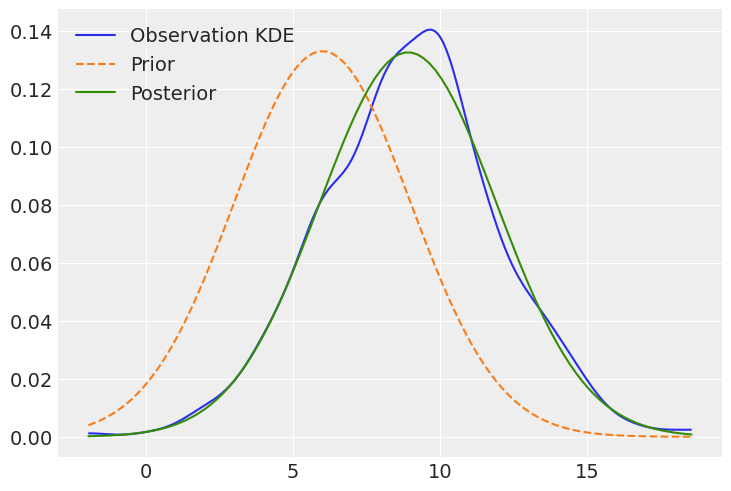

In [8]:
fig, ax = plt.subplots()

az.plot_kde(X, ax = ax, label="Observation KDE")
x = np.linspace(X.min(), X.max(), 100)
ax.plot(x, scratch_prior.pdf(x), color = "C1", linestyle = "--", label = "Prior")
ax.plot(x, scratch_predictive.pdf(x), color = "C2", label = "Posterior")
ax.legend(loc=2)
plt.show();

### PyMC3

In [9]:
with pm.Model() as m:
    # Estimating mean of the data, and first guess is that it follows Normal distribution with mean 3 and std 1
    mu = pm.Normal("mu", mu = 3, sigma = 3)
    obs = pm.Normal("obs", mu = mu, sigma = 3, observed = X)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Output()

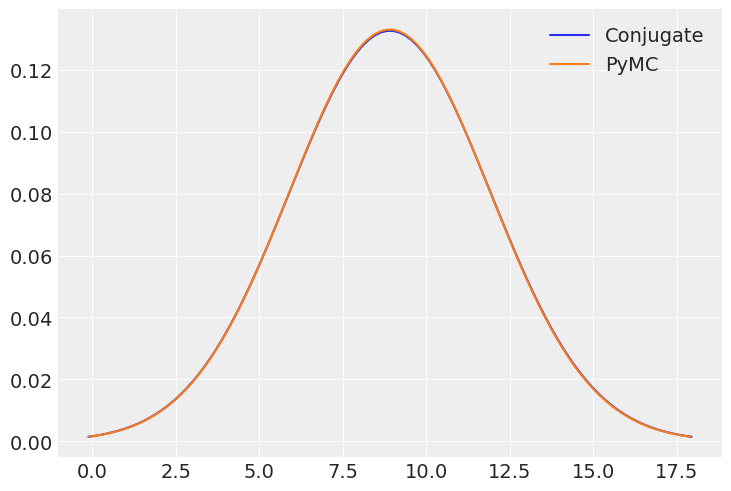

In [10]:
prior = idata.prior
post = idata.posterior

pp_mean = post["mu"].mean()

# Exact calculation
pred_std = posterior_std + prior_std
z1 = np.linspace(posterior_mean - 3* pred_std, posterior_mean + 3*pred_std, 100)
conj_pdf= stats.norm(posterior_mean, pred_std).pdf(z1)

#Pymc params
z2 = np.linspace(pp_mean - 9, pp_mean + 9, 100)
pymc_pdf = stats.norm(pp_mean, 3).pdf(z2)

fig, ax = plt.subplots()
ax.plot(z1, conj_pdf, label = "Conjugate")
ax.plot(z2, pymc_pdf, label = "PyMC")
ax.legend()
plt.show();


#### DDKS

In [8]:
pymc_samples = torch.Tensor(stats.norm(pp_mean, 3).rvs(100).reshape(-1, 1))
conj_samples= torch.Tensor(stats.norm(posterior_mean, pred_std).rvs(100).reshape(-1, 1))

calculation = ddks.methods.ddKS()
distance = calculation(conj_samples, pymc_samples)
print(f"The ddKS distance is {distance}")

The ddKS distance is 0.11000001430511475


In [14]:
kl_divergence(scratch_predictive, stats.norm(pp_mean, 3), -10, 20, 1000)

4.314085088785481e-06

### Pyro

In [18]:
def pyro_model(X):
    mu = pyro.sample("mu", pyro_dist.Normal(3, 3))

    with pyro.plate("data", n):
        pyro.sample("obs", pyro_dist.Normal(mu, sigma), obs=X)

In [21]:
kernel = pyro.infer.NUTS(pyro_model)

mcmc = pyro.infer.MCMC(kernel, num_samples = 1000, warmup_steps = 200)
mcmc.run(torch.Tensor(X))

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Warmup:   0%|          | 0/1200 [00:00, ?it/s]

Sample: 100%|██████████| 1200/1200 [00:01, 767.15it/s, step size=9.42e-01, acc. prob=0.940]


In [25]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: mu
       mean      std        5%       25%       50%       75%       95%
0  8.906308  0.09197  8.759087  8.842963  8.906748  8.968261  9.057042 



### Stan

In [42]:
from cmdstanpy import CmdStanModel
import os

stan_file = os.path.join("../whats_your_bench/stan_models/normalKnownVar.stan")

model = CmdStanModel(stan_file = stan_file)

stan_data = {
    "N": X1.shape[0],
    "X": X1,
    "prior_mu": 3,
    "prior_sigma": 3,
    "obs_sigma": 3
}

fit = model.sample(data = stan_data)
fit.summary()

15:55:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:55:01 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-516.48000,0.018131,0.715087,-517.8990,-516.20800,-515.97400,1555.6,31112.0,1.00139
mu,8.75191,0.002361,0.095662,8.5945,8.75105,8.90924,1642.1,32842.0,1.00111


## Normal with known mean $\mu$

$$
\mu = 0\\
$$

$$
P(x_i | \theta) \sim \mathcal{N}(\mu, \sigma^2)\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\nu, \sigma_0^2)\\
$$

$$
P(\theta | \Theta') \sim \mathcal{N} (\nu + \eta, \frac{\nu \sigma_0^2 + \sum_{i=1}^n ( x_i - \mu)^2}{\nu + \eta})\\
$$

$$
P(\tilde{x} | \Theta') \sim \mathcal{t}_{\nu'}(\tilde{x} | \mu, \sigma_{0}^{2'})
$$

### Scratch

In [53]:
n = 100
mu = 3
prior_alpha = 1
prior_beta = 1

X = stats.norm.rvs(loc = mu, scale = 0.9, size = n)

posterior_alpha = prior_alpha + n/2
posterior_beta = prior_beta + 0.5 * np.sum(np.power(X - mu, 2))

predictive = stats.t(posterior_alpha, loc = mu, scale = np.sqrt(posterior_beta/posterior_alpha))

In [54]:
print(np.sqrt(posterior_beta/posterior_alpha))
print(posterior_alpha)

0.8301448643307516
51.0


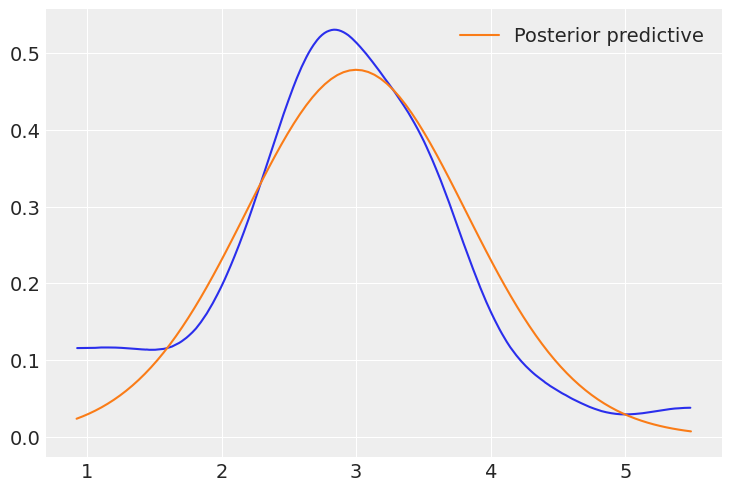

In [55]:
fig, ax = plt.subplots()

az.plot_kde(X, ax = ax)
x = np.linspace(X.min(), X.max(), 100)
ax.plot(x, predictive.pdf(x), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

### PyMC3

In [56]:
with pm.Model() as m:
    # Priors for unknown model parameters
    nu = pm.HalfNormal("nu", sigma = 0.1)
    sigma = pm.HalfNormal("sigma", sigma = 0.1)
    
    # Likelihood
    obs = pm.StudentT("obs", nu = nu, mu = 3, sigma = sigma, observed = X)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [nu, obs, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

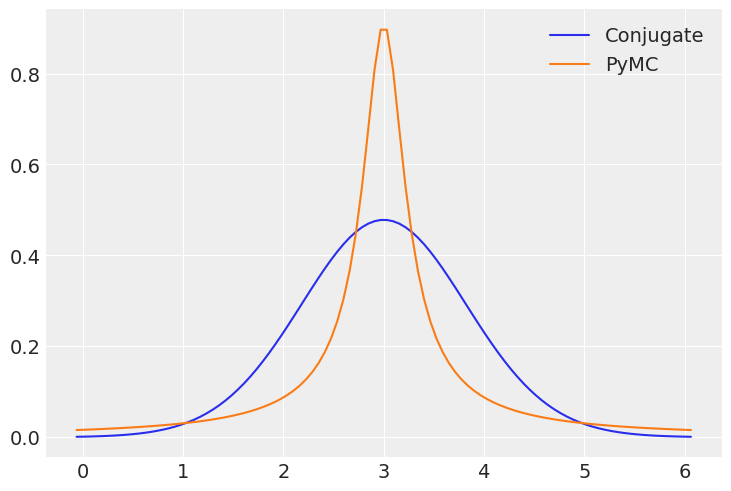

In [57]:
post = idata.posterior

post_scale = post["sigma"].mean().values
post_nu = post["nu"].mean().values

# Exact calculation
conj_std = np.sqrt(posterior_alpha/(posterior_alpha-2))
z1 = np.linspace(3-3*conj_std, 3+3*conj_std, 100)
conj_pred = predictive.pdf(z1)

#Pymc params
pymc_pred = stats.t(df = post_nu, loc = 3, scale = post_scale).pdf(z1)

fig, ax = plt.subplots()
ax.plot(z1, conj_pred, label = "Conjugate")
ax.plot(z1, pymc_pred, label = "PyMC")
ax.legend()
plt.show();


### Pyro

In [23]:
def _setup_pyro_model():

    nu = pyro.sample(
        "nu",
        pyro_dist.HalfNormal(10)
    )

    sigma = pyro.sample(
        "sigma",
        pyro_dist.HalfNormal(10)
    )

    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", pyro_dist.StudentT(nu, 0, sigma), obs = torch.Tensor(X))

kernel = pyro.infer.NUTS(_setup_pyro_model)

mcmc = pyro.infer.MCMC(kernel, num_samples = 1000, warmup_steps = 200)
mcmc.run()

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:05, 215.32it/s, step size=8.37e-01, acc. prob=0.875]


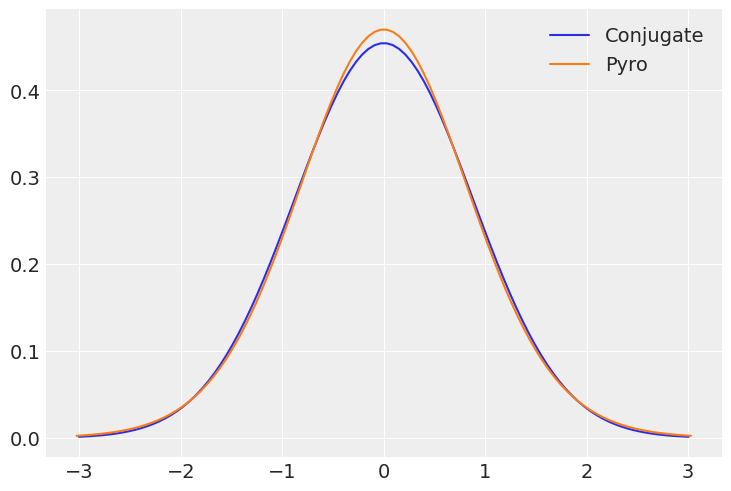

In [24]:
post_scale = hmc_samples["sigma"].mean()
post_nu = hmc_samples["nu"].mean()

# Exact calculation
conj_std = np.sqrt(posterior_alpha/(posterior_alpha-2))
z1 = np.linspace(0-3*conj_std, 0+3*conj_std, 100)
conj_pred = predictive.pdf(z1)

#Pymc params
pymc_pred = stats.t(df = post_nu, loc = 0, scale = post_scale).pdf(z1)

fig, ax = plt.subplots()
ax.plot(z1, conj_pred, label = "Conjugate")
ax.plot(z2, pymc_pred, label = "Pyro")
ax.legend()
plt.show();


### Stan

In [26]:
from cmdstanpy import CmdStanModel
import os

stan_file = os.path.join("../whats_your_bench/stan_models/normalKnownMean.stan")

model = CmdStanModel(stan_file = stan_file)

stan_data = {
    "N": X.shape[0],
    "X": X,
    "prior_nu": 10,
    "prior_sigma": 10,
    "obs_mean": 0
}

fit = model.sample(data = stan_data)
fit.summary()

12:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:21:05 - cmdstanpy - INFO - CmdStan done processing.
12:21:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
	Exception: student_t_lpdf: Degrees of freedom parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
	Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-717.455000,0.022476,0.971641,-719.434000,-717.174000,-716.519000,1868.82,8815.18,1.00058
nu,20.588700,0.118274,5.413020,12.653600,20.056800,30.079500,2094.61,9880.25,1.00051
sigma,0.837617,0.000479,0.022055,0.800828,0.837511,0.873994,2117.39,9987.71,1.00134


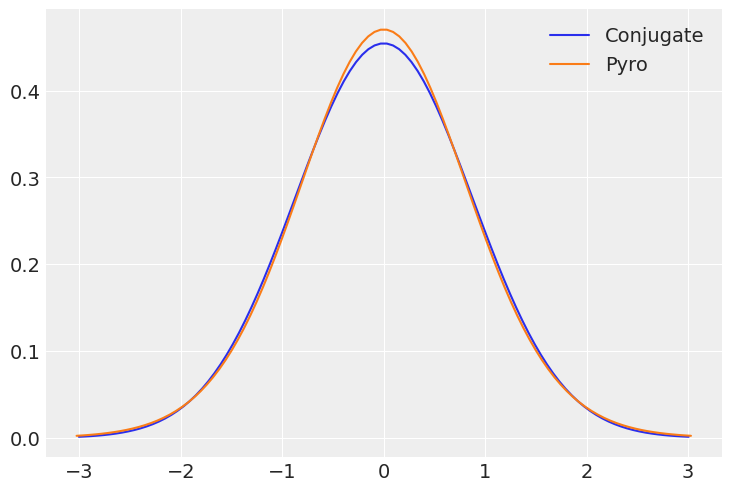

In [28]:
post_nu = fit.nu.mean()
post_scale = fit.sigma.mean()

# Exact calculation
conj_std = np.sqrt(posterior_alpha/(posterior_alpha-2))
z1 = np.linspace(0-3*conj_std, 0+3*conj_std, 100)
conj_pred = predictive.pdf(z1)

#Pymc params
pymc_pred = stats.t(df = post_nu, loc = 0, scale = post_scale).pdf(z1)

fig, ax = plt.subplots()
ax.plot(z1, conj_pred, label = "Conjugate")
ax.plot(z2, pymc_pred, label = "Stan")
ax.legend()
plt.show();


## Multivariate Normal with known covariance $\mathbf{\Sigma}$

$$
\mathbf{\Sigma} = \begin{pmatrix}
\text{Var}(X) & \text{Cov}(X,Y) & \text{Cov}(X,Z) \\
\text{Cov}(Y,X) & \text{Var}(Y) & \text{Cov}(Y,Z) \\
\text{Cov}(Z,X) & \text{Cov}(Z,Y) & \text{Var}(Z) \\
\end{pmatrix}\\
$$

$$
P(x_i | \theta) \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\mu_0, \mathbf{\Sigma_0})\\
$$

$$
P(\theta | \Theta') \sim \mathcal{N}((\mathbf{\Sigma}_0^{-1} + n\mathbf{\Sigma}^{-1})^{-1}(\mathbf{\Sigma}_0^{-1}\mu_0 + n\mathbf{\Sigma}^{-1}\mathbf{\bar{x}}), (\mathbf{\Sigma}_0^{-1}+n\mathbf{\Sigma}^{-1})^{-1})
$$

$$
P(\tilde{x}|\Theta') \sim \mathcal{N}(\mathbf{\tilde{x}}|\mu_0', {\mathbf{\Sigma}_0' + \mathbf{\Sigma}})
$$

### Scratch

In [18]:
n = 100
mu = np.array([3, 5])
cov = np.array([[1, 0.5], [0.5, 1]])

X2 = stats.multivariate_normal.rvs(mean = mu, cov = cov, size = n)

prior_mu = np.array([0, 0])
prior_cov = cov

posterior_mu = np.linalg.inv(np.linalg.inv(prior_cov) + n*np.linalg.inv(cov)) @ (np.linalg.inv(prior_cov) @ prior_mu + n * np.linalg.inv(cov) @ X2.mean(axis = 0))
posterior_cov = np.linalg.inv(np.linalg.inv(prior_cov) + n*np.linalg.inv(cov))

predictive = stats.multivariate_normal(mean = posterior_mu, cov = posterior_cov + cov)

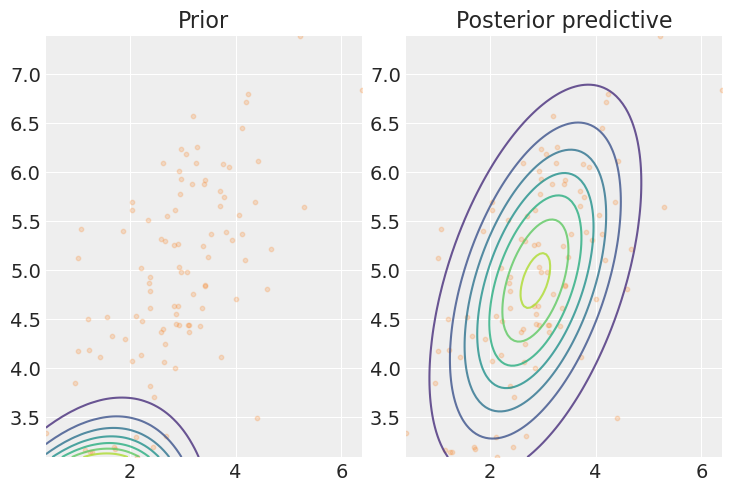

In [8]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_normal.pdf(pos, mean = prior_mu, cov = prior_cov), alpha = 0.8)
ax[1].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

### PyMC3

In [30]:
with pm.Model() as m:
    # Priors for unknown model parameters
    mu = pm.MvNormal("mu", mu = [1,1], cov = [[1,0],[0,1]], shape = 2)
    
    # Likelihood
    obs = pm.MvNormal("obs", mu = mu, cov = cov, observed = X)

    idata = pm.sample(cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Warmup:   0%|          | 0/1200 [14:09, ?it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


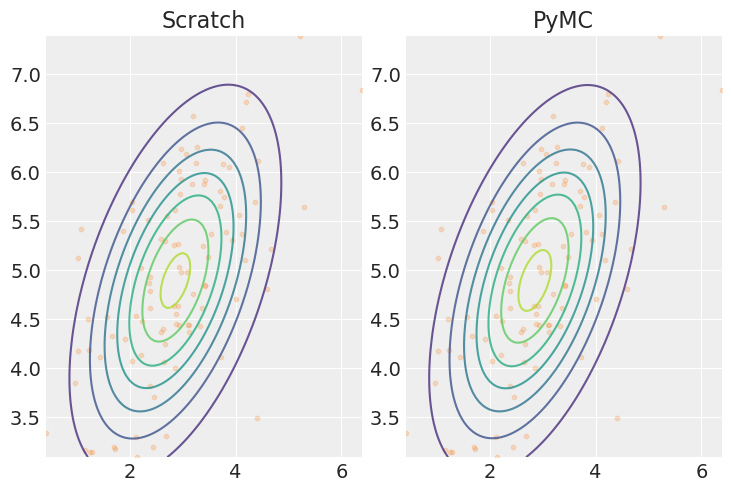

In [16]:
post = idata.posterior

pp_mean = post["mu"].mean(axis = 0).mean(axis = 0)

# Set up the grid
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

# Exact calculation
ax[0].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Scratch")

#Pymc params
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = pp_mean, cov = cov), alpha = 0.8)
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].set_title("PyMC")

plt.show();


In [20]:
print(post["mu"].mean(axis = 0).mean(axis = 0).values)

[2.85170407 4.89182274]


### Pyro

In [26]:
def pyro_model():
    mu = pyro.sample("mu", pyro_dist.MultivariateNormal(torch.Tensor([1, 1]), torch.Tensor([[1,0],[0,1]])))

    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", pyro_dist.MultivariateNormal(torch.Tensor(mu), torch.Tensor(cov)), obs = torch.Tensor(X))

kernel = pyro.infer.NUTS(pyro_model)

mcmc = pyro.infer.MCMC(kernel, num_samples = 1000, warmup_steps = 200)
mcmc.run()

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Warmup:   0%|          | 0/1200 [00:00, ?it/s]

Sample: 100%|██████████| 1200/1200 [00:03, 348.50it/s, step size=8.57e-01, acc. prob=0.886]


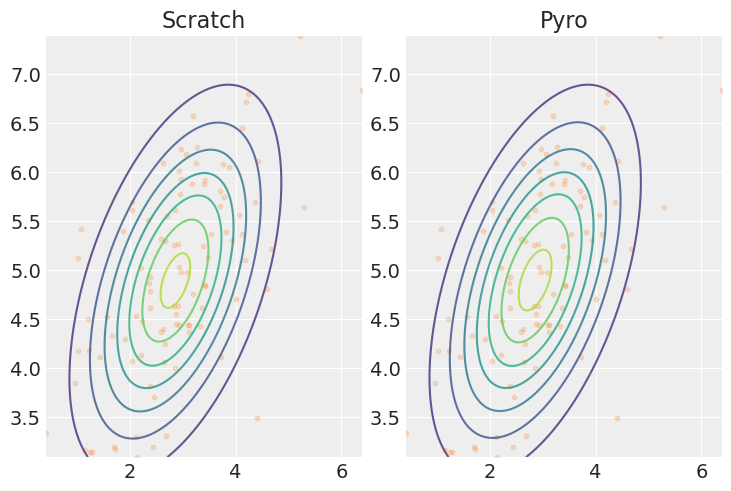

In [34]:
pp_mean = hmc_samples["mu"].mean(axis = 0)

# Set up the grid
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

# Exact calculation
ax[0].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Scratch")

#Pymc params
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = pp_mean, cov = cov), alpha = 0.8)
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].set_title("Pyro")

plt.show();


### Stan

In [9]:
X2.shape

(100, 2)

In [14]:
from cmdstanpy import CmdStanModel
import os

stan_file = os.path.join("../whats_your_bench/stan_models/mvNormalKnownCov.stan")

model = CmdStanModel(stan_file = stan_file)

stan_data = {
    "N": X2.shape[0],
    "M": X2.shape[1],
    "X": X2,
    "prior_mu": [1, 1],
    "prior_sigma": [[1, 0], [0, 1]],
    "obs_sigma": cov
}

fit = model.sample(data = stan_data)
fit.summary()

16:29:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:29:46 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-108.83100,0.025283,1.060200,-111.04100,-108.49300,-107.84500,1758.45,1384.60,1.00171
mu[1],2.91598,0.002447,0.100529,2.75435,2.91594,3.08343,1687.54,1328.77,1.00224
mu[2],4.88203,0.002413,0.100867,4.71707,4.88237,5.05060,1747.04,1375.62,1.00184


In [26]:
fit.mu.mean(axis = 0)

array([2.91597506, 4.88203496])

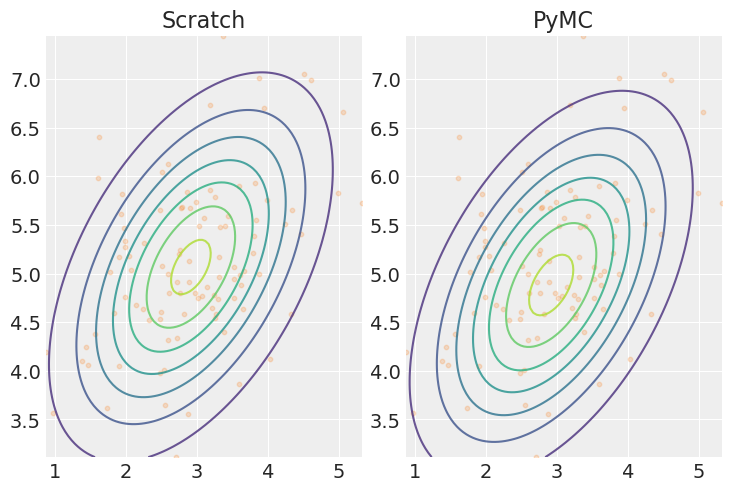

In [19]:
pp_mean = [fit.summary().loc["mu[1]", "Mean"], fit.summary().loc["mu[2]", "Mean"]]

# Set up the grid
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X2[:, 0].min(), X2[:, 0].max(), 100)
z2 = np.linspace(X2[:, 1].min(), X2[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

# Exact calculation
ax[0].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X2[:, 0], X2[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Scratch")

#Pymc params
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = pp_mean, cov = cov), alpha = 0.8)
ax[1].scatter(X2[:, 0], X2[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].set_title("PyMC")

plt.show();

## Multivariate Normal with known mean $\mu$



### Scratch

In [61]:
from types import SimpleNamespace

class MvNormalKnownMean():
    def __init__(
            self,
            mean,
            prior_params
            ):
        
        self.prior_params = SimpleNamespace(**prior_params)

        self.mu = mean

    def find_predictive_posterior(
            self,
            data
        ):

        N = data.shape[0]
        p = self.prior_params.psi.shape[1]

        self.posterior_params = SimpleNamespace(
            nu = N + self.prior_params.nu,
            psi = self.prior_params.psi + np.sum((data - self.mu) @ (data - self.mu).T)
        )

        self.posterior_predictive_params = SimpleNamespace(
            nu = self.posterior_params.nu - p + 1,
            loc = self.mu,
            psi = (1/(self.posterior_params.nu - p + 1)) * self.posterior_params.psi
        )

        self.predictive_dist = stats.multivariate_t(
            df = self.posterior_predictive_params.nu,
            loc = self.mu,
            shape = self.posterior_predictive_params.psi
        )

In [62]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

X = stats.multivariate_normal([3, 5], [[0.7926, 0.9706], [0.9706, 1.2245]]).rvs(30)

mv_normal = MvNormalKnownMean([3, 5], {"nu": 1, "psi": np.array([[1, 0], [0, 1]])})

mv_normal.find_predictive_posterior(X)

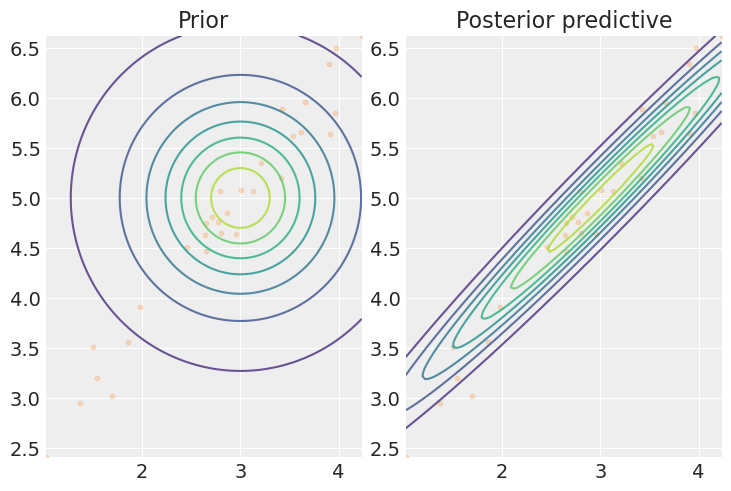

In [63]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = [3, 5], df = mv_normal.prior_params.nu, shape = mv_normal.prior_params.psi), alpha = 0.8)
ax[1].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

### PyMC

In [158]:
N = X.shape[0]
d = X.shape[1]

coords = {"axis": [f"x{i+1}" for i in range(d)], "axis_bis": [f"x{i+1}" for i in range(d)], "obs_id": np.arange(N)}

with pm.Model(coords=coords) as model:

    nu = pm.Normal("nu", mu = 30, sigma = 1)

    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=5, sd_dist=pm.HalfCauchy.dist(beta = 2, shape=2)
    )
    # scale = pm.Deterministic("scale", chol.dot(chol.T), dims=("axis", "axis_bis"))

    obs = pm.MvStudentT("obs", nu=nu, mu = [3,5], chol = chol, observed=X, dims=("obs_id", "axis"))

    trace = pm.sample(
        idata_kwargs={"dims": {"chol_stds": ["axis"], "chol_corr": ["axis", "axis_bis"]}},
    )
az.summary(trace, var_names="~chol", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, chol]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
/opt/miniconda3/envs/ppl_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_corr[x1, x1]",1.00,0.00,1.00,1.00,0.00,0.00,4000.00,4000.00,NaN
"chol_corr[x1, x2]",0.95,0.02,0.92,0.98,0.00,0.00,2355.60,2359.80,1.0
"chol_corr[x2, x1]",0.95,0.02,0.92,0.98,0.00,0.00,2355.60,2359.80,1.0
"chol_corr[x2, x2]",1.00,0.00,1.00,1.00,0.00,0.00,3745.33,3529.54,1.0
chol_stds[x1],0.76,0.09,0.59,0.94,0.00,0.00,1793.78,1830.97,1.0
chol_stds[x2],0.95,0.11,0.73,1.16,0.00,0.00,1838.29,1954.57,1.0
nu,30.03,1.01,28.12,31.94,0.02,0.01,2996.66,2529.73,1.0


In [162]:
trace.posterior

<xarray.Dataset> Size: 328kB
Dimensions:     (chain: 4, draw: 1000, chol_dim_0: 3, axis: 2, axis_bis: 2)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * chol_dim_0  (chol_dim_0) int64 24B 0 1 2
  * axis        (axis) <U2 16B 'x1' 'x2'
  * axis_bis    (axis_bis) <U2 16B 'x1' 'x2'
Data variables:
    chol        (chain, draw, chol_dim_0) float64 96kB 0.6671 0.7622 ... 0.3337
    chol_corr   (chain, draw, axis, axis_bis) float64 128kB 1.0 0.9418 ... 1.0
    chol_stds   (chain, draw, axis) float64 64kB 0.6671 0.8093 ... 0.9228 1.09
    nu          (chain, draw) float64 32kB 29.81 29.72 30.42 ... 30.69 29.31
Attributes:
    created_at:                 2024-08-15T15:24:36.096153+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              10.315605640411377
    tuning_steps:               1000

In [154]:
trace.posterior.nu.mean(axis = 0). mean(axis=0).values

array(30.03318895)

In [155]:
mv_normal.posterior_predictive_params

namespace(nu=30,
          loc=[3, 5],
          psi=array([[1.82052702, 1.78719368],
                     [1.78719368, 1.82052702]]))

/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_52420/3723430133.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8, label = "Conjugate")
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_52420/3723430133.py:10: UserWarning: The following kwargs were not used by contour: 'df'
  ax[1].contour(x, y, stats.multivariate_t.pdf(


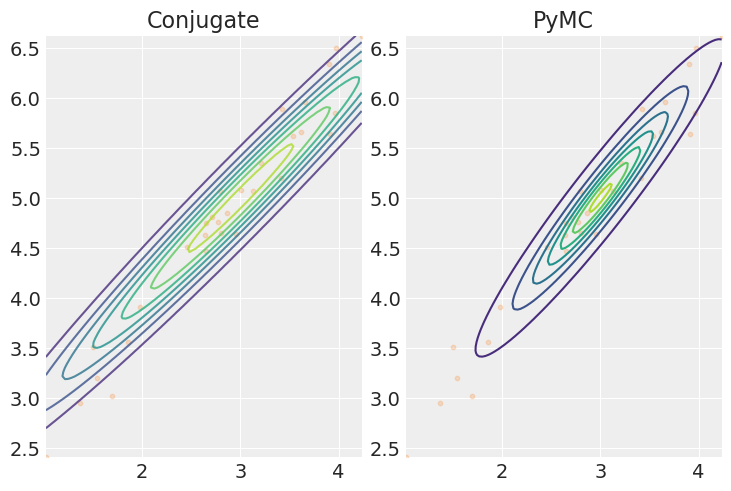

In [157]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

#ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = [3, 5], df = mv_normal.prior_params.nu, shape = mv_normal.prior_params.psi), alpha = 0.8)
ax[0].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8, label = "Conjugate")
ax[1].contour(x, y, stats.multivariate_t.pdf(
    pos,
    loc = [3,5],
    shape = trace.posterior.scale.mean(axis = 0).mean(axis = 0).values),
    df = trace.posterior.nu.mean(axis = 0).values
    )

ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Conjugate")
ax[1].set_title("PyMC")

plt.show();

### Pyro

In [20]:
def pyro_model():
    N, M = X.shape

    nu = pyro.sample("nu", pyro_dist.HalfNormal(10))

    # Sample the standard deviations with an exponential prior
    sigma = pyro.sample("sigma", pyro_dist.HalfCauchy(10).expand([M]))

    # Sample the correlation matrix using the LKJ prior
    Omega = pyro.sample("Omega", pyro_dist.LKJCholesky(M, 10))

    # Construct the covariance matrix
    scale = torch.mm(torch.diag(sigma), torch.mm(Omega, torch.diag(sigma)))

    # Observe data
    with pyro.plate("observations", N):
        pyro.sample("obs", pyro_dist.MultivariateStudentT(
            df = nu,
            loc = torch.Tensor([3, 5]),
            scale_tril=scale
            ), obs=torch.Tensor(X))

kernel = pyro.infer.NUTS(pyro_model)

mcmc = pyro.infer.MCMC(kernel, num_samples = 1000, warmup_steps = 200)
mcmc.run()

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample:  47%|████▋     | 565/1200 [00:14, 62.93it/s, step size=3.36e-01, acc. prob=0.928]

In [24]:
D = np.diag(np.sqrt(hmc_samples["sigma"].mean(axis = 0)))
L = np.matrix(hmc_samples["Omega"].mean(axis = 0))

cov = D @ L @ L.T @ D

In [22]:
hmc_samples["nu"].mean()

9.550282

In [25]:
cov

matrix([[0.8069325 , 0.82797366],
        [0.82797366, 0.95073634]], dtype=float32)

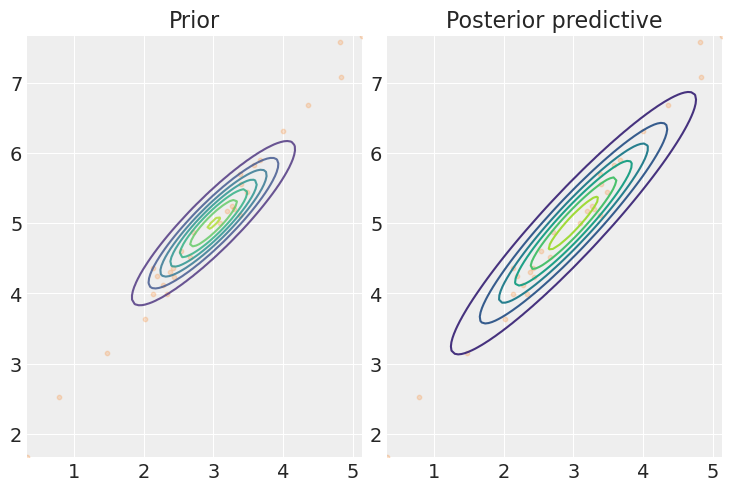

In [60]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

#ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = [3, 5], df = mv_normal.prior_params.nu, shape = mv_normal.prior_params.psi), alpha = 0.8)
ax[0].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8)
ax[1].contour(x, y, stats.multivariate_t.pdf(pos, df = hmc_samples["nu"].mean(), loc = [3,5], shape = cov))

ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

### Stan

In [62]:
from cmdstanpy import CmdStanModel
import os

stan_file = os.path.join("../whats_your_bench/stan_models/mvNormalKnownMean.stan")

model = CmdStanModel(stan_file = stan_file)

stan_data = {
    "N": X.shape[0],
    "M": X.shape[1],
    "X": X,
    "prior_beta": 10,
    "prior_eta": 10,
    "prior_nu": 10,
    "obs_mean": [3, 5]
}

fit = model.sample(data = stan_data)
fit.summary()

13:49:19 - cmdstanpy - INFO - compiling stan file /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean.stan to exe file /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean
13:49:35 - cmdstanpy - INFO - compiled model executable: /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean
13:49:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:37 - cmdstanpy - INFO - CmdStan done processing.
13:49:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: l

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-34.027200,0.036187,1.405060e+00,-36.753300,-33.691900,-32.399100,1507.56000,861.46000,1.00088
sigma[1],0.732844,0.003081,1.120050e-01,0.554261,0.730096,0.924981,1321.83000,755.32900,1.00500
sigma[2],0.894926,0.003794,1.384980e-01,0.674771,0.888772,1.129600,1332.72000,761.55200,1.00427
"L[1,1]",1.000000,NaN,6.000000e-16,1.000000,1.000000,1.000000,NaN,NaN,NaN
"L[1,2]",0.000000,NaN,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN
"L[2,1]",0.937817,0.000760,3.196810e-02,0.877780,0.944470,0.974663,1769.23000,1010.99000,1.00272
"L[2,2]",0.336460,0.001854,7.921420e-02,0.223434,0.328605,0.479024,1824.86000,1042.78000,1.00281
nu,8.290720,0.110650,4.743250e+00,2.688130,7.167420,17.860800,1837.71606,1050.12346,1.00167
"Psi[1,1]",0.549602,0.004514,1.673610e-01,0.307205,0.533041,0.855590,1374.85000,785.63000,1.00540
"Psi[1,2]",0.630946,0.005425,1.984100e-01,0.347893,0.609403,0.986748,1337.75000,764.43000,1.00544


/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_80968/846501426.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8, label = "Conjugate")


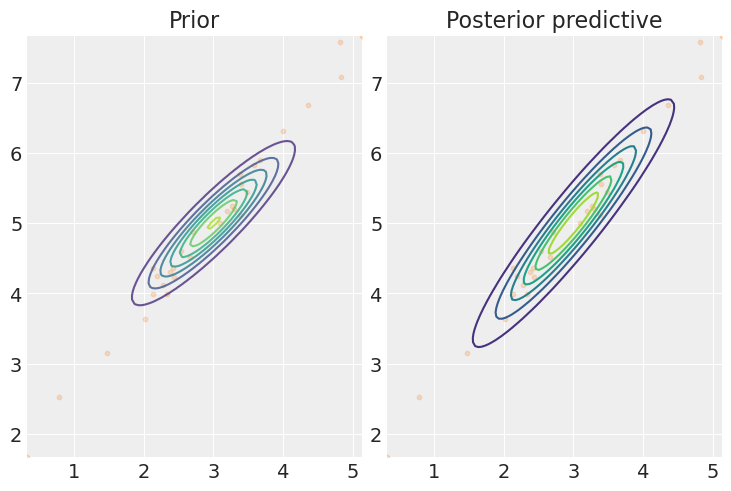

In [64]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

#ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = [3, 5], df = mv_normal.prior_params.nu, shape = mv_normal.prior_params.psi), alpha = 0.8)
ax[0].contour(x, y, mv_normal.predictive_dist.pdf(pos), alpha = 0.8, label = "Conjugate")
ax[1].contour(x, y, stats.multivariate_t.pdf(
    pos,
    df = fit.nu.mean(),
    loc = [3,5],
    shape = fit.Psi.mean(axis = 0)))

ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

## Archive models

In [ ]:
N = 30
d = 2

coords = {"axis": [f"x{i+1}" for i in range(d)], "axis_bis": [f"x{i+1}" for i in range(d)], "obs_id": np.arange(N)}

with pm.Model(coords=coords) as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("axis", "axis_bis"))
    obs = pm.MvNormal("obs", [3,5], chol=chol, observed=X, dims=("obs_id", "axis"))

    trace = pm.sample(
        idata_kwargs={"dims": {"chol_stds": ["axis"], "chol_corr": ["axis", "axis_bis"]}},
    )
az.summary(trace, var_names="~chol", round_to=2)